## Assignment

### EMOTION PREDICTION IN CONVERSATIONS:




In [2]:
import nltk
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### LOADING DATA
- DATASET : MELD : https://affective-meld.github.io/


In [5]:
train = pd.read_csv('train_sent.csv')
cv = pd.read_csv('dev_sent.csv')
test = pd.read_csv('test_sent.csv')

### EXPLORATORY DATA ANALYSIS

In [6]:
train.columns

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')

In [8]:
train.head(10)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
5,6,"Now youll be heading a whole division, so you...",The Interviewer,neutral,neutral,0,5,8,21,"00:16:41,126","00:16:44,337"
6,7,I see.,Chandler,neutral,neutral,0,6,8,21,"00:16:48,800","00:16:51,886"
7,8,But therell be perhaps 30 people under you so...,The Interviewer,neutral,neutral,0,7,8,21,"00:16:48,800","00:16:54,514"
8,9,Good to know.,Chandler,neutral,neutral,0,8,8,21,"00:16:59,477","00:17:00,478"
9,10,We can go into detail,The Interviewer,neutral,neutral,0,9,8,21,"00:17:00,478","00:17:02,719"


In [9]:
train.shape, cv.shape , test.shape

((9989, 11), (1109, 11), (2610, 11))

### Missing value analysis

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
Sr No.          9989 non-null int64
Utterance       9989 non-null object
Speaker         9989 non-null object
Emotion         9989 non-null object
Sentiment       9989 non-null object
Dialogue_ID     9989 non-null int64
Utterance_ID    9989 non-null int64
Season          9989 non-null int64
Episode         9989 non-null int64
StartTime       9989 non-null object
EndTime         9989 non-null object
dtypes: int64(5), object(6)
memory usage: 858.5+ KB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
Sr No.          2610 non-null int64
Utterance       2610 non-null object
Speaker         2610 non-null object
Emotion         2610 non-null object
Sentiment       2610 non-null object
Dialogue_ID     2610 non-null int64
Utterance_ID    2610 non-null int64
Season          2610 non-null int64
Episode         2610 non-null int64
StartTime       2610 non-null object
EndTime         2610 non-null object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


In [15]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
Sr No.          1109 non-null int64
Utterance       1109 non-null object
Speaker         1109 non-null object
Emotion         1109 non-null object
Sentiment       1109 non-null object
Dialogue_ID     1109 non-null int64
Utterance_ID    1109 non-null int64
Season          1109 non-null int64
Episode         1109 non-null int64
StartTime       1109 non-null object
EndTime         1109 non-null object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


### Distribution plots

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64


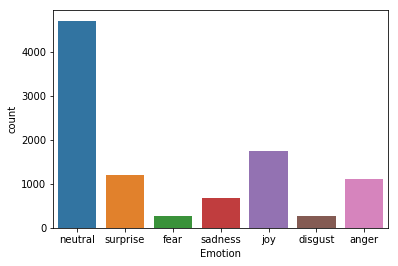

In [10]:
#Imbalanced Data
ax = sns.countplot(x=train['Emotion'], data=train)
print(train['Emotion'].value_counts())

neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: Emotion, dtype: int64


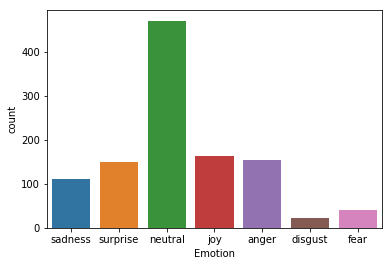

In [11]:
#Imbalanced Data
ax = sns.countplot(x=cv['Emotion'], data=cv)
print(cv['Emotion'].value_counts())

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64


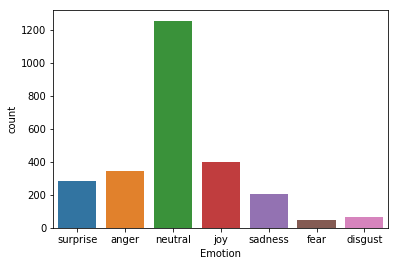

In [12]:
#Imbalanced Data
ax = sns.countplot(x=test['Emotion'], data=test)
print(test['Emotion'].value_counts())

### Observation:-
- Their is no missing values present in our dataset.
- the distribution of train , cv and test data points are same.


## Splits

In [15]:
X_train , y_train = train[['Utterance']] , train[['Emotion']]
X_cv , y_cv = cv[['Utterance']] , cv[['Emotion']]
X_test , y_test = test[['Utterance']] , test[['Emotion']]

## Data preprocessing

In [16]:
import re

### Dataset Preprocessing training set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
train_corpus = []
for i in range(0, len(X_train)):
    review = re.sub('[^a-zA-Z]', ' ', X_train['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    train_corpus.append(review)

In [19]:
import re

### Dataset Preprocessing cv set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
cv_corpus = []
for i in range(0, len(X_cv)):
    review = re.sub('[^a-zA-Z]', ' ', X_cv['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    cv_corpus.append(review)

In [20]:
import re

### Dataset Preprocessing test set
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
test_corpus = []
for i in range(0, len(X_test)):
    review = re.sub('[^a-zA-Z]', ' ', X_test['Utterance'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    test_corpus.append(review)

## Defining Multi Class LogLoss

In [16]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Define a scorer to be used in Grid Search

In [17]:
scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

### Vectorization

In [18]:
enc = preprocessing.LabelEncoder()
y_train_enc = enc.fit_transform(y_train.Emotion.values)
y_cv_enc = enc.transform(y_cv.Emotion.values)
y_test_enc = enc.transform(y_test.Emotion.values)

In [21]:
X_train['clean_utterance'] = train_corpus
X_train.drop('Utterance',axis=1,inplace=True)
X_cv['clean_utterance'] = cv_corpus
X_cv.drop('Utterance',axis=1,inplace=True)
X_test['clean_utterance'] = test_corpus
X_test.drop('Utterance',axis=1,inplace=True)

###  MODELLING

### Logistic regression

In [27]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_tfv =  tfv.transform(X_train['clean_utterance']) 
X_valid_tfv = tfv.transform(X_cv['clean_utterance'])
X_test_tfv = tfv.transform(X_test['clean_utterance'])

In [22]:
X_train_tfv.shape

(9989, 3179)


In [23]:
X_valid_tfv.shape

(1109, 3179)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression()

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_tfv, y_train_enc)

# Summarize results
print("Best score: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']



Fitting 2 folds for each of 9 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.1s finished
Best score: -1.417605 using {'C': 1}


In [ ]:
lr = LogisticRegression(C = 1)
lr.fit(X_train_tfv, y_train_enc)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Train,Test and CV loss


In [26]:
predictions = lr.predict_proba(X_train_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.119 


In [27]:
predictions = lr.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.325 


In [28]:
predictions = lr.predict_proba(X_test_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.271 


In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70
a =list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance'])
token.fit_on_texts(a)
xtrain_seq = token.texts_to_sequences(X_train['clean_utterance'])
xvalid_seq = token.texts_to_sequences(X_cv['clean_utterance'])
xtest_seq = token.texts_to_sequences(X_test['clean_utterance'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [31]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history=model.fit(xtrain_pad, y=y_train_enc_nn, batch_size=512, epochs=200, verbose=1, validation_data=(xvalid_pad, y_cv_enc_nn), callbacks=[earlystop])

Train on 9989 samples, validate on 1109 samples
Epoch 1/200
9989/9989 [==============================] - 7s 658us/step - loss: 1.9394 - val_loss: 1.9347
Epoch 2/200
9989/9989 [==============================] - 6s 584us/step - loss: 1.9256 - val_loss: 1.9239
Epoch 3/200
9989/9989 [==============================] - 6s 593us/step - loss: 1.9122 - val_loss: 1.9134
Epoch 4/200
9989/9989 [==============================] - 6s 573us/step - loss: 1.8992 - val_loss: 1.9032
Epoch 5/200
9989/9989 [==============================] - 6s 587us/step - loss: 1.8867 - val_loss: 1.8934
Epoch 6/200
9989/9989 [==============================] - 6s 585us/step - loss: 1.8744 - val_loss: 1.8839
Epoch 7/200
9989/9989 [==============================] - 6s 591us/step - loss: 1.8627 - val_loss: 1.8746
Epoch 8/200
9989/9989 [==============================] - 6s 589us/step - loss: 1.8512 - val_loss: 1.8656
Epoch 9/200
9989/9989 [==============================] - 6s 593us/step - loss: 1.8400 - val_loss: 1.8569
Epoch 1

### Bi -LSTM


In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history=model.fit(xtrain_pad, y=y_train_enc_nn, batch_size=512, epochs=200, verbose=1, validation_data=(xvalid_pad, y_cv_enc_nn), callbacks=[earlystop])

Train on 9989 samples, validate on 1109 samples
Epoch 1/200
9989/9989 [==============================] - 13s 1ms/step - loss: 1.9397 - val_loss: 1.9351
Epoch 2/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.9259 - val_loss: 1.9240
Epoch 3/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.9122 - val_loss: 1.9135
Epoch 4/200
9989/9989 [==============================] - 11s 1ms/step - loss: 1.8991 - val_loss: 1.9033
Epoch 5/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8864 - val_loss: 1.8934
Epoch 6/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8742 - val_loss: 1.8838
Epoch 7/200
9989/9989 [==============================] - 11s 1ms/step - loss: 1.8623 - val_loss: 1.8745
Epoch 8/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8508 - val_loss: 1.8655
Epoch 9/200
9989/9989 [==============================] - 12s 1ms/step - loss: 1.8396 - val_loss: 1.8567
Epoch 10/200
998

In [ ]:
from sklearn.externals import joblib 
joblib.dump(lr, 'lr2.pkl') 
joblib.dump(tfv, 'tfidf.pkl') 

### Testing Model

In [33]:
from sklearn.externals import joblib 
def predictor(sentence):
    lst = []
    my_model = joblib.load('lr2.pkl') 
    tfv = joblib.load('tfidf.pkl')  

    sent = preprocessor(sentence)

    lst.append(sent)
    sent_tfv = tfv.transform(lst)
    ans = my_model.predict(sent_tfv) 
    mapped_ans = mapper(ans)
    return mapped_ans

In [35]:
import re

### Dataset Preprocessing 
from nltk.stem.porter import PorterStemmer
def preprocessor(sentence):
    ps = PorterStemmer()

    review = re.sub('[^a-zA-Z]', ' ', sentence)
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [36]:
def mapper(val):
    for i in val:
    if i==0:
        return 'Anger'
    elif i==1:
        return 'Disgust'
    elif i==2:
        return 'Fear'
    elif i==3:
        return 'Joy'
    elif i==4:
        return 'Neutral'
    elif i==5:
        return 'Sadness'
    elif i==6:
        return 'Surprise'
    
    

In [37]:
val = predictor('oh! that is a good news')
print(val)

joy


In [38]:
val = predictor('i do not like that thing')
print(val)

anger
